# Exploratory Data Analysis

#### Importing Necessary Libraries

In [1]:
import seaborn as sns
import math as math
from random import gauss as gs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import itertools
from pmdarima import auto_arima
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

#statsmodels
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from keras.preprocessing.sequence import TimeseriesGenerator

### Functions For EDA

#### Function for cleaning up -999 when rides are closed

In [2]:
def CleanNegatives(df,Tag,CleanName):
    InBlock = False  # Tags that I am inside of a -999 block
    Start = 0
    End   = 0
    Clean = df[Tag]
    for Index in range(len(Clean)):
        if InBlock:
            if Clean[Index] > 0: # Exit condition 
                End = Index
                InBlock = False
                if Start ==0:
                    AVG = Clean[End]
                elif End == len(Clean) - 1:
                    AVG = Clean[Start]
                else:
                    AVG = (Clean[Start-1]+Clean[End])/2
                # Cleaning negatives, replacing by average at the endpoints of the block
                for NewIndex in range(Start,End):
                    Clean[NewIndex] = AVG
        else:  # Not In the block
            if Clean[Index] < 0: # Enter condition
                Start = Index
                InBlock = True
    df[CleanName] = Clean
                

#### Function for merging columns

In [3]:
def Cleanup(df,Tag1,Tag2,ResultTag):
    Clean = []
    for i in range(len(df)):
        Value = ( df[Tag1][i] if not math.isnan(df[Tag1][i]) else df[Tag2][i])
        Clean.append(Value)
    df[ResultTag] = Clean

#### Function to test stationairy

In [4]:
def test_stationarity(timeseries, window):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries.iloc[window:], color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
                                             'p-value', '#Lags Used',
                                             'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print (dfoutput)

## MAGIC KINGDOM

### 7 Dwarfs Mine Train

In [5]:
df_mk_7dwarfs = pd.read_csv("data/7_dwarfs_train.csv")
df_mk_7dwarfs

,date,datetime,SACTMIN,SPOSTMIN
0,01/01/2015,2015-01-01 07:51:12,NaN,45.0
1,01/01/2015,2015-01-01 08:02:13,NaN,60.0
2,01/01/2015,2015-01-01 08:05:30,54.0,NaN
3,01/01/2015,2015-01-01 08:09:12,NaN,60.0
4,01/01/2015,2015-01-01 08:16:12,NaN,60.0
...,...,...,...,...
321626,12/28/2021,2021-12-28 22:42:15,NaN,45.0
321627,12/28/2021,2021-12-28 22:48:12,NaN,45.0
321628,12/28/2021,2021-12-28 22:54:10,NaN,45.0
321629,12/28/2021,2021-12-28 22:54:28,10.0,NaN


#### Cleaning up data: Removing -999. Taking average of day before and after

In [6]:
CleanNegatives(df_mk_7dwarfs,'SPOSTMIN','SPOSTMINClean')
print(df_mk_7dwarfs)

<ipython-input-2-a4f54c8aedc8>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Clean[NewIndex] = AVG


              date             datetime  SACTMIN  SPOSTMIN  SPOSTMINClean
0       01/01/2015  2015-01-01 07:51:12      NaN      45.0           45.0
1       01/01/2015  2015-01-01 08:02:13      NaN      60.0           60.0
2       01/01/2015  2015-01-01 08:05:30     54.0       NaN            NaN
3       01/01/2015  2015-01-01 08:09:12      NaN      60.0           60.0
4       01/01/2015  2015-01-01 08:16:12      NaN      60.0           60.0
...            ...                  ...      ...       ...            ...
321626  12/28/2021  2021-12-28 22:42:15      NaN      45.0           45.0
321627  12/28/2021  2021-12-28 22:48:12      NaN      45.0           45.0
321628  12/28/2021  2021-12-28 22:54:10      NaN      45.0           45.0
321629  12/28/2021  2021-12-28 22:54:28     10.0       NaN            NaN
321630  12/28/2021  2021-12-28 22:57:34      NaN      35.0           35.0

[321631 rows x 5 columns]


#### Merging columns

In [7]:
Cleanup(df_mk_7dwarfs,'SACTMIN','SPOSTMINClean','CleanTime')
print(df_mk_7dwarfs)

              date             datetime  SACTMIN  SPOSTMIN  SPOSTMINClean  \
0       01/01/2015  2015-01-01 07:51:12      NaN      45.0           45.0   
1       01/01/2015  2015-01-01 08:02:13      NaN      60.0           60.0   
2       01/01/2015  2015-01-01 08:05:30     54.0       NaN            NaN   
3       01/01/2015  2015-01-01 08:09:12      NaN      60.0           60.0   
4       01/01/2015  2015-01-01 08:16:12      NaN      60.0           60.0   
...            ...                  ...      ...       ...            ...   
321626  12/28/2021  2021-12-28 22:42:15      NaN      45.0           45.0   
321627  12/28/2021  2021-12-28 22:48:12      NaN      45.0           45.0   
321628  12/28/2021  2021-12-28 22:54:10      NaN      45.0           45.0   
321629  12/28/2021  2021-12-28 22:54:28     10.0       NaN            NaN   
321630  12/28/2021  2021-12-28 22:57:34      NaN      35.0           35.0   

        CleanTime  
0            45.0  
1            60.0  
2            54

In [8]:
df_mk_7dwarfs[df_mk_7dwarfs.CleanTime < 0]

,date,datetime,SACTMIN,SPOSTMIN,SPOSTMINClean,CleanTime
105109,02/20/2017,2017-02-20 09:04:37,-92918.0,NaN,NaN,-92918.0


In [9]:
df_mk_7dwarfs = df_mk_7dwarfs[df_mk_7dwarfs['CleanTime'] >= 0]

In [10]:
df_mk_7dwarfs[df_mk_7dwarfs.CleanTime < 0]

,date,datetime,SACTMIN,SPOSTMIN,SPOSTMINClean,CleanTime


In [11]:
df_mk_7dwarfs

,date,datetime,SACTMIN,SPOSTMIN,SPOSTMINClean,CleanTime
0,01/01/2015,2015-01-01 07:51:12,NaN,45.0,45.0,45.0
1,01/01/2015,2015-01-01 08:02:13,NaN,60.0,60.0,60.0
2,01/01/2015,2015-01-01 08:05:30,54.0,NaN,NaN,54.0
3,01/01/2015,2015-01-01 08:09:12,NaN,60.0,60.0,60.0
4,01/01/2015,2015-01-01 08:16:12,NaN,60.0,60.0,60.0
...,...,...,...,...,...,...
321626,12/28/2021,2021-12-28 22:42:15,NaN,45.0,45.0,45.0
321627,12/28/2021,2021-12-28 22:48:12,NaN,45.0,45.0,45.0
321628,12/28/2021,2021-12-28 22:54:10,NaN,45.0,45.0,45.0
321629,12/28/2021,2021-12-28 22:54:28,10.0,NaN,NaN,10.0


In [12]:
df_mk_7dwarfs['datetime'] = pd.to_datetime(df_mk_7dwarfs.datetime)
df_mk_7dwarfs.set_index('datetime', inplace=True)


<ipython-input-12-6e5af379a8a1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mk_7dwarfs['datetime'] = pd.to_datetime(df_mk_7dwarfs.datetime)


In [13]:
df_mk_7dwarfs = df_mk_7dwarfs['CleanTime']

In [14]:
df_mk_7dwarfs

datetime
2015-01-01 07:51:12    45.0
2015-01-01 08:02:13    60.0
2015-01-01 08:05:30    54.0
2015-01-01 08:09:12    60.0
2015-01-01 08:16:12    60.0
                       ... 
2021-12-28 22:42:15    45.0
2021-12-28 22:48:12    45.0
2021-12-28 22:54:10    45.0
2021-12-28 22:54:28    10.0
2021-12-28 22:57:34    35.0
Name: CleanTime, Length: 321524, dtype: float64

In [15]:
df_mk_7dwarfs.isna().sum()

0

In [16]:
df_mk_7dwarfs_daily = df_mk_7dwarfs.resample('D').mean()

<AxesSubplot:xlabel='datetime'>

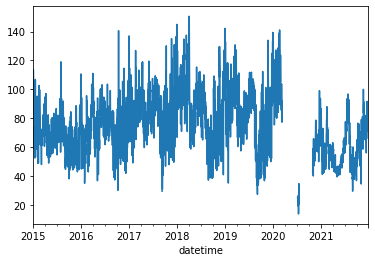

In [17]:
df_mk_7dwarfs_daily.plot()

In [18]:
df_mk_7dwarfs_daily = df_mk_7dwarfs_daily.loc['2015-01-01 07:51:12':'2019-12-31 23:55:02']

In [19]:
df_mk_7dwarfs_daily 

datetime
2015-01-02    112.993421
2015-01-03    100.469697
2015-01-04     79.685039
2015-01-05     87.370690
2015-01-06     79.066667
                 ...    
2019-12-27     91.559441
2019-12-28     88.639286
2019-12-29     93.121429
2019-12-30    116.776978
2019-12-31    133.416149
Freq: D, Name: CleanTime, Length: 1825, dtype: float64

In [20]:
df_mk_7dwarfs_daily[df_mk_7dwarfs_daily.isna()]

datetime
2017-09-10   NaN
2017-09-11   NaN
Freq: D, Name: CleanTime, dtype: float64

In [21]:
df_mk_7dwarfs_daily = df_mk_7dwarfs_daily.ffill()

In [22]:
df_mk_7dwarfs_daily

datetime
2015-01-02    112.993421
2015-01-03    100.469697
2015-01-04     79.685039
2015-01-05     87.370690
2015-01-06     79.066667
                 ...    
2019-12-27     91.559441
2019-12-28     88.639286
2019-12-29     93.121429
2019-12-30    116.776978
2019-12-31    133.416149
Freq: D, Name: CleanTime, Length: 1825, dtype: float64

In [23]:
df_mk_7dwarfs_daily[df_mk_7dwarfs_daily.isna()]

Series([], Freq: D, Name: CleanTime, dtype: float64)

<AxesSubplot:xlabel='datetime'>

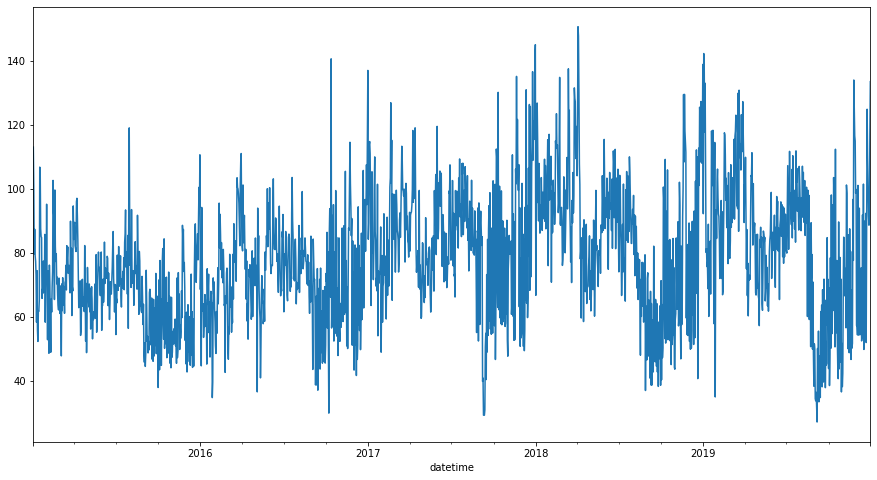

In [24]:
df_mk_7dwarfs_daily.plot(figsize=(15,8))

In [25]:
pvalue = adfuller(df_mk_7dwarfs_daily)[1]
is_stationary = pvalue<= .05

is_stationary

True

In [26]:
# test_stationarity(df_mk_7dwarfs_daily, 4)

In [27]:
df_mk_7dwarfs_daily.shape

(1825,)

#### Finding the index which allows us to split off 20% of the data

In [28]:
cutoff = round(df_mk_7dwarfs_daily.shape[0]*0.8)
cutoff

1460

#### Define train and test sets according to the index found above

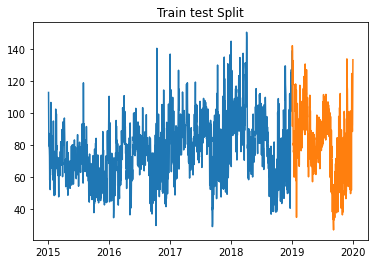

In [29]:
train = df_mk_7dwarfs_daily[:cutoff]
test = df_mk_7dwarfs_daily[cutoff:]

fig, ax = plt.subplots()
ax.plot(train)
ax.plot(test)
ax.set_title('Train test Split');

#### Facebook's Prophet - Baseline Model

In [30]:
from fbprophet import Prophet
import logging

logging.getLogger().setLevel(logging.ERROR)

In [31]:
df = df_mk_7dwarfs_daily.reset_index()
df.columns = ['ds', 'y']
df.head()

,ds,y
0,2015-01-02,112.993421
1,2015-01-03,100.469697
2,2015-01-04,79.685039
3,2015-01-05,87.370690
4,2015-01-06,79.066667


In [32]:
prediction_size = 30
train_df = df[:-prediction_size]

In [33]:
train_df

,ds,y
0,2015-01-02,112.993421
1,2015-01-03,100.469697
2,2015-01-04,79.685039
3,2015-01-05,87.370690
4,2015-01-06,79.066667
...,...,...
1790,2019-11-27,116.532787
1791,2019-11-28,114.885496
1792,2019-11-29,98.628788
1793,2019-11-30,99.791667


In [34]:
m = Prophet()
m.fit(train_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [35]:
future = m.make_future_dataframe(periods=365)

forecast = m.predict(future)

In [36]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-02,66.307211,63.446658,102.295688,66.307211,66.307211,16.928495,16.928495,16.928495,-5.142890,-5.142890,-5.142890,22.071385,22.071385,22.071385,0.0,0.0,0.0,83.235706
1,2015-01-03,66.313900,77.550938,112.285463,66.313900,66.313900,29.464191,29.464191,29.464191,7.719827,7.719827,7.719827,21.744364,21.744364,21.744364,0.0,0.0,0.0,95.778091
2,2015-01-04,66.320589,63.510559,101.777051,66.320589,66.320589,16.440267,16.440267,16.440267,-4.701929,-4.701929,-4.701929,21.142196,21.142196,21.142196,0.0,0.0,0.0,82.760856
3,2015-01-05,66.327277,74.456882,110.233905,66.327277,66.327277,25.657222,25.657222,25.657222,5.375671,5.375671,5.375671,20.281551,20.281551,20.281551,0.0,0.0,0.0,91.984499
4,2015-01-06,66.333966,65.582488,100.674017,66.333966,66.333966,16.522607,16.522607,16.522607,-2.661522,-2.661522,-2.661522,19.184129,19.184129,19.184129,0.0,0.0,0.0,82.856573


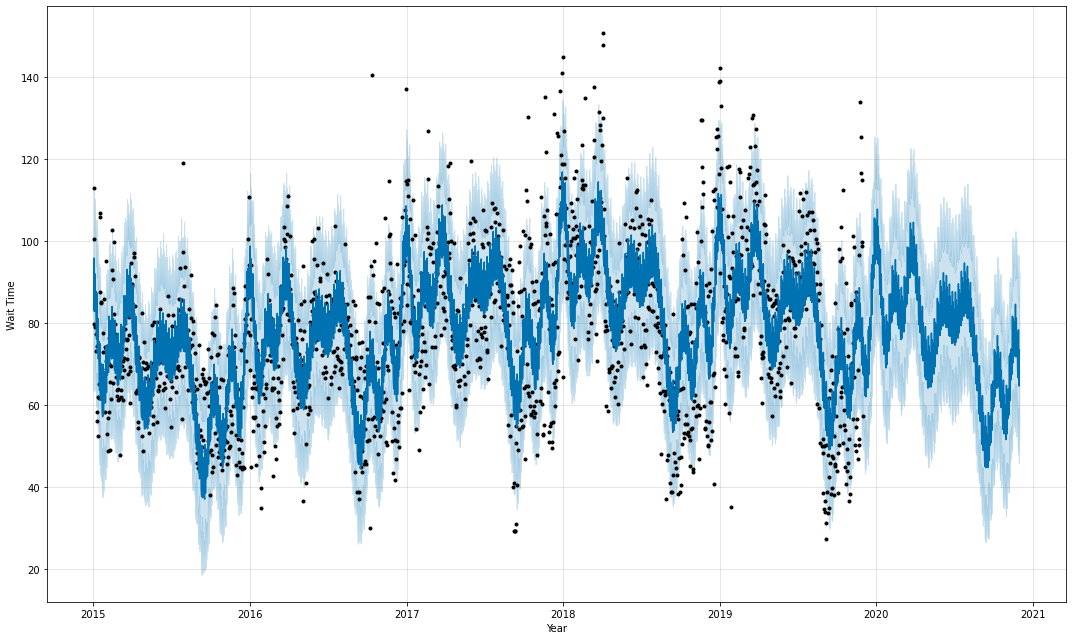

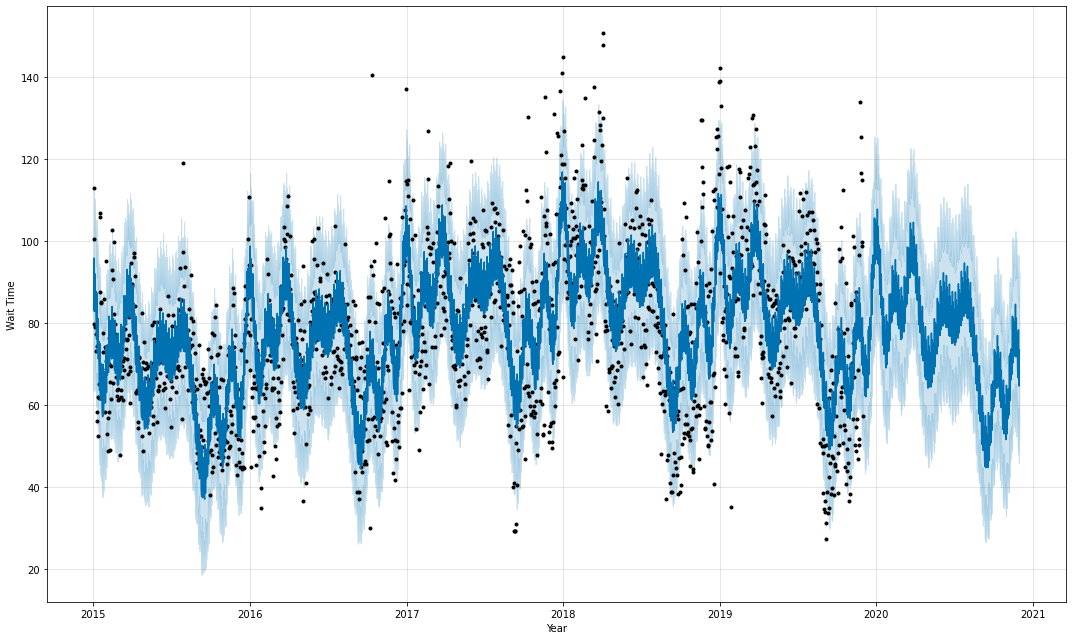

In [37]:
m.plot(forecast,
       xlabel='Year',
       ylabel='Wait Time',
       figsize=(15, 9),)

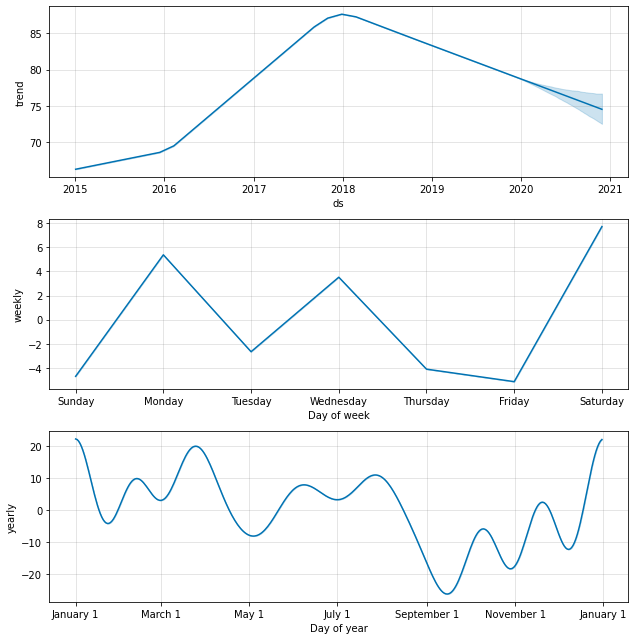

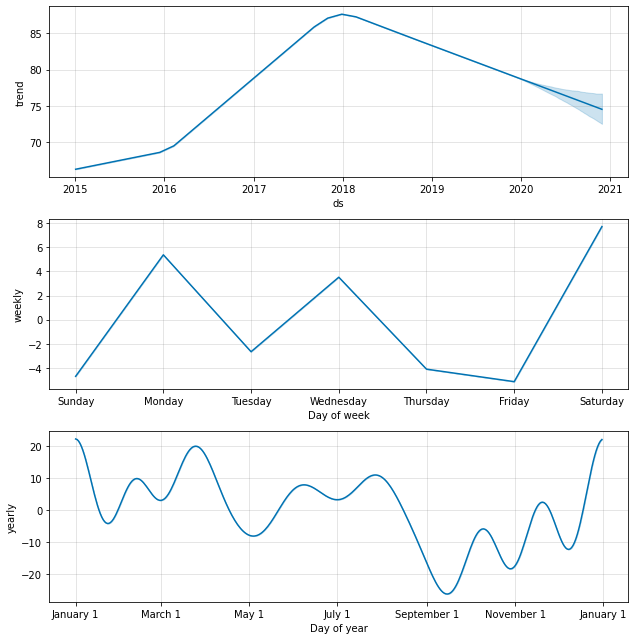

In [38]:
m.plot_components(forecast)


In [39]:
def make_comparison_dataframe(historical, forecast):
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

In [40]:
cmp_df = make_comparison_dataframe(df, forecast)

cmp_df.head()

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2015-01-02,83.235706,63.446658,102.295688,112.993421
2015-01-03,95.778091,77.550938,112.285463,100.469697
2015-01-04,82.760856,63.510559,101.777051,79.685039
2015-01-05,91.984499,74.456882,110.233905,87.370690
2015-01-06,82.856573,65.582488,100.674017,79.066667


In [41]:
def calculate_forecast_errors(df, prediction_size):
    
    df = df.copy()
    
    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']
    
    predicted_part = df[-prediction_size:]
    
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    
    return {'MAPE': error_mean('p'), 'MAE': error_mean('e')}

In [42]:
for err_name, err_value in calculate_forecast_errors(cmp_df, prediction_size).items():
    print(err_name, err_value)

MAPE nan
MAE nan


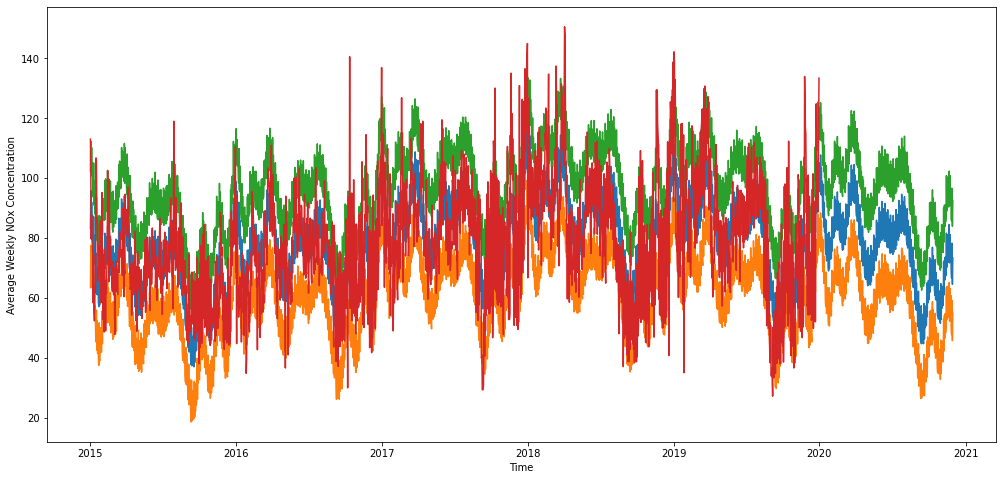

In [43]:
plt.figure(figsize=(17, 8))
plt.plot(cmp_df['yhat'])
plt.plot(cmp_df['yhat_lower'])
plt.plot(cmp_df['yhat_upper'])
plt.plot(cmp_df['y'])
plt.xlabel('Time')
plt.ylabel('Average Weekly NOx Concentration')
plt.grid(False)
plt.show()

#### Evaluating the Model

In [44]:
df_merge = pd.merge(train_df, forecast[['ds','yhat_lower','yhat_upper','yhat']],on='ds')
df_merge = df_merge[['ds','yhat_lower','yhat_upper','yhat','y']]
df_merge.head()

,ds,yhat_lower,yhat_upper,yhat,y
0,2015-01-02,63.446658,102.295688,83.235706,112.993421
1,2015-01-03,77.550938,112.285463,95.778091,100.469697
2,2015-01-04,63.510559,101.777051,82.760856,79.685039
3,2015-01-05,74.456882,110.233905,91.984499,87.370690
4,2015-01-06,65.582488,100.674017,82.856573,79.066667


In [45]:
# calculate MAE between observed and predicted values 
y_true = df_merge['y'].values
y_pred = df_merge['yhat'].values
mae_01 = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae_01)

MAE: 11.205


In [46]:
mape_01 = mean_absolute_percentage_error(y_true, y_pred)
print('MAPE: %.3f' % mape_01)

MAPE: 0.156


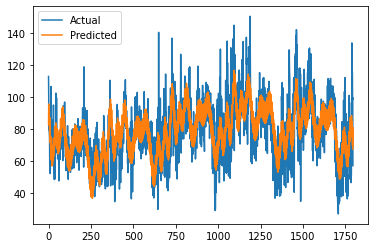

In [47]:
# plot expected vs actual
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()


#### Grid Search - Fine Tuning Parameters

In [53]:
import itertools

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],   
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
maes = []  # Store the MAE for each params here
mapes = [] # Store the MAPE for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train_df)  # Fit model with given params
    df_cv = cross_validation(m, horizon='90 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    maes.append(df_p['mae'].values[0])
    mapes.append(df_p['mape'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mae'] = maes
tuning_results['mape'] = mapes

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 30 forecasts with cutoffs between 2016-02-05 00:00:00 and 2019-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x1740153d0>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 30 forecasts with cutoffs between 2016-02-05 00:00:00 and 2019-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x1725dc970>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 30 forecasts with cutoffs between 2016-02-05 00:00:00 and 2019-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x17403d040>
INFO:fbprophet:Disabling daily seasonality. Run prophet wi

In [54]:
tuning_results_df = pd.DataFrame(tuning_results)

In [55]:
tuning_results_df.sort_values(['mae','mape'])

,changepoint_prior_scale,seasonality_prior_scale,mae,mape
6,0.010,1.00,13.640683,0.187434
7,0.010,10.00,13.645783,0.187349
5,0.010,0.10,13.664394,0.187480
11,0.100,10.00,13.794981,0.186097
10,0.100,1.00,13.814496,0.186545
9,0.100,0.10,13.831744,0.186717
4,0.010,0.01,13.852922,0.192081
15,0.500,10.00,14.202646,0.189343
14,0.500,1.00,14.203224,0.189591
13,0.500,0.10,14.223204,0.189956


In [56]:
tuning_results_df.sort_values(['mape','mae'])

,changepoint_prior_scale,seasonality_prior_scale,mae,mape
11,0.100,10.00,13.794981,0.186097
10,0.100,1.00,13.814496,0.186545
9,0.100,0.10,13.831744,0.186717
7,0.010,10.00,13.645783,0.187349
6,0.010,1.00,13.640683,0.187434
5,0.010,0.10,13.664394,0.187480
15,0.500,10.00,14.202646,0.189343
14,0.500,1.00,14.203224,0.189591
13,0.500,0.10,14.223204,0.189956
4,0.010,0.01,13.852922,0.192081


In [57]:
best_params = all_params[np.argmin(mapes)]
print(best_params)

{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0}


#### Best Model

In [58]:
m = Prophet(interval_width=0.95, weekly_seasonality=True, 
            changepoint_prior_scale=best_params['changepoint_prior_scale'], 
            seasonality_prior_scale=best_params['seasonality_prior_scale'])
model = m.fit(train_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [59]:
future = m.make_future_dataframe(periods=365) #to predict 3 years in the future

In [60]:
forecast = m.predict(future)

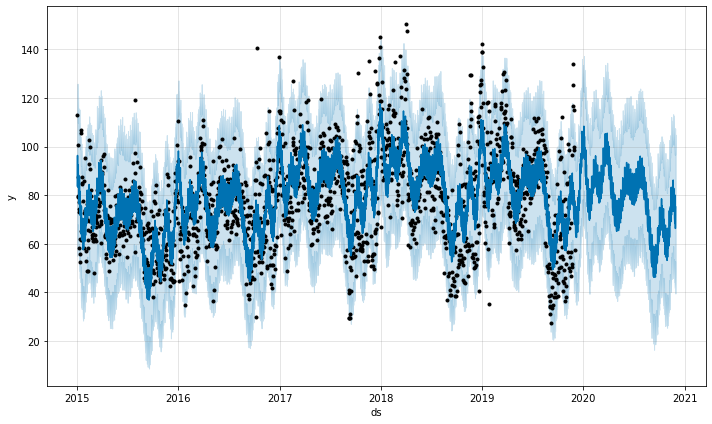

In [61]:
plot1 = m.plot(forecast)

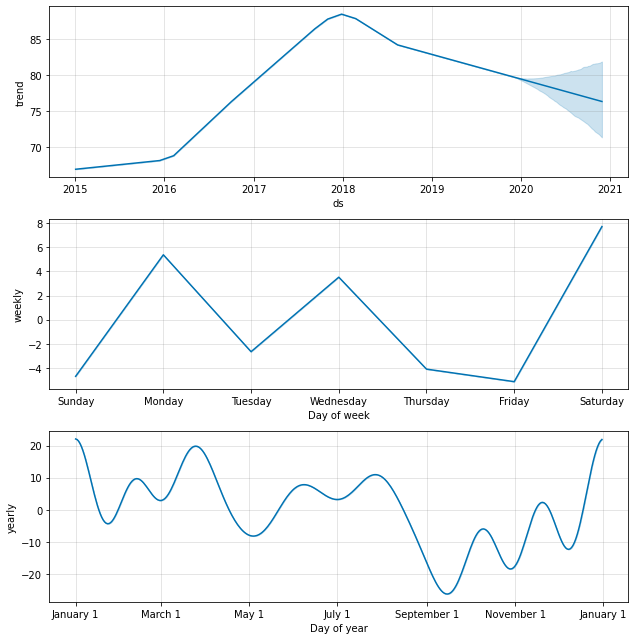

In [62]:
plot2 = m.plot_components(forecast)

In [63]:
df_merge = pd.merge(train_df, forecast[['ds','yhat_lower','yhat_upper','yhat']],on='ds')
df_merge = df_merge[['ds','yhat_lower','yhat_upper','yhat','y']]

In [64]:
# calculate MAE between expected and predicted values for december
y_true = df_merge['y'].values
y_pred = df_merge['yhat'].values
mae_02 = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae_02)

MAE: 11.172


In [65]:
mape_02 = mean_absolute_percentage_error(y_true, y_pred)
print('MAPE: %.3f' % mape_02)

MAPE: 0.155


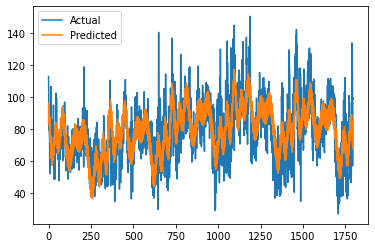

In [66]:
# plot expected vs actual
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [67]:
metrics_prophet_01 = [round(mae_01,3), 
                 round(mape_01,3)]

metrics_prophet_02 = [round(mae_02,3), 
                 round(mape_02,3)]

In [68]:
pd.DataFrame({'metrics':['MAE','MAPE'],
              'Prophet_01':metrics_prophet_01, 
              'Prophet_02':metrics_prophet_02,
             })

,metrics,Prophet_01,Prophet_02
0,MAE,11.205,11.172
1,MAPE,0.156,0.155


#### Best Model w/ Holidays - BEST MODEL

In [69]:
# m = Prophet(interval_width=0.95, weekly_seasonality=True, 
#             changepoint_prior_scale=best_params['changepoint_prior_scale'], 
#             seasonality_prior_scale=best_params['seasonality_prior_scale'])
# m.add_country_holidays(country_name='US')
# model = m.fit(train_df)

In [70]:
m = Prophet(interval_width=0.95, weekly_seasonality=True, 
            changepoint_prior_scale= .10, 
            seasonality_prior_scale= 10)
m.add_country_holidays(country_name='US')
model = m.fit(train_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [71]:
# holidays included
m.train_holiday_names

0                  New Year's Day
1      Martin Luther King Jr. Day
2           Washington's Birthday
3                    Memorial Day
4                Independence Day
5                       Labor Day
6                    Columbus Day
7                    Veterans Day
8                    Thanksgiving
9                   Christmas Day
10       Christmas Day (Observed)
11      New Year's Day (Observed)
12        Veterans Day (Observed)
13    Independence Day (Observed)
dtype: object

In [72]:
future = m.make_future_dataframe(periods=365) #to predict 1 year in the future

In [73]:
forecast = m.predict(future)

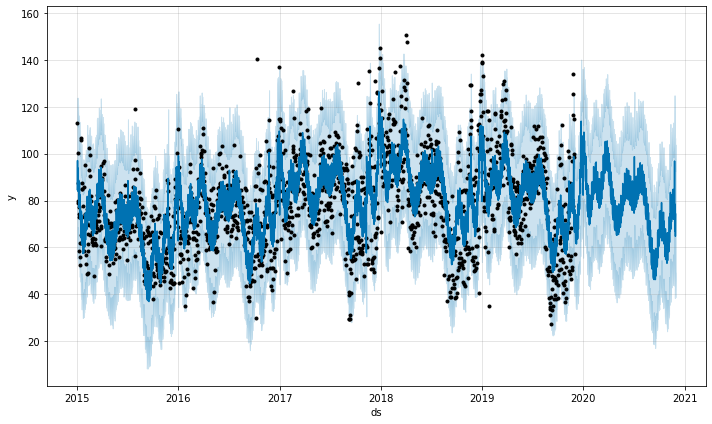

In [74]:
plot3 = m.plot(forecast)


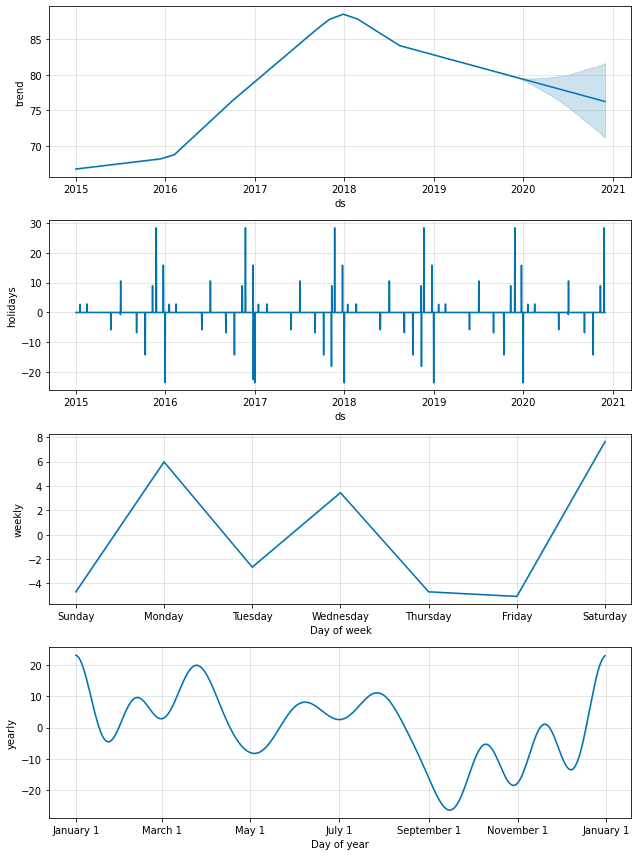

In [75]:
plot4 = m.plot_components(forecast)


In [76]:
df_merge = pd.merge(train_df, forecast[['ds','yhat_lower','yhat_upper','yhat']],on='ds')
df_merge = df_merge[['ds','yhat_lower','yhat_upper','yhat','y']]

In [77]:
# calculate MAE between expected and predicted values for december
y_true = df_merge['y'].values
y_pred = df_merge['yhat'].values
mae_03 = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae_03)

MAE: 11.016


In [78]:
mape_03 = mean_absolute_percentage_error(y_true, y_pred)
print('MAPE: %.3f' % mape_03)

MAPE: 0.153


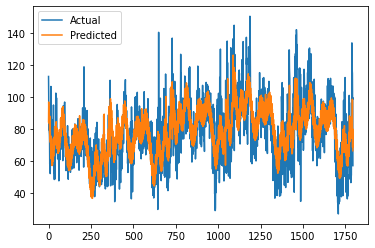

In [79]:
# plot expected vs actual
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [80]:
df_cv = cross_validation(m, horizon='90 days')
# df_cv = cross_validation(m, initial='270 days', period='45 days', horizon = '90 days')

INFO:fbprophet:Making 30 forecasts with cutoffs between 2016-02-05 00:00:00 and 2019-09-02 00:00:00


In [81]:
metrics_prophet_03 = [round(mae_03,3), 
                 round(mape_03,3)]

In [84]:
pd.DataFrame({'metrics':['MAE','MAPE'],
              'Prophet_01':metrics_prophet_01, 
              'Prophet_02':metrics_prophet_02,
              'Prophet_03':metrics_prophet_03,
             })

,metrics,Prophet_01,Prophet_02,Prophet_03
0,MAE,11.205,11.172,11.016
1,MAPE,0.156,0.155,0.153


In [82]:
fb_metrics = pd.DataFrame({'metrics':['MAE','MAPE'],
              'Prophet_01':metrics_prophet_01, 
              'Prophet_02':metrics_prophet_02,
              'Prophet_03':metrics_prophet_03,
             })

<BarContainer object of 3 artists>

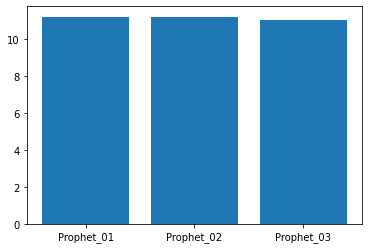

In [83]:
plt.bar(fb_metrics.columns[1:], fb_metrics.iloc[0, 1:])

#### Attempt at Keras

In [ ]:
# # define generator
# n_input = 3
# n_features = 1
# generator = TimeseriesGenerator(train, train, length=n_input, batch_size=1)

In [ ]:
# X,y = generator[0]
# print(f'Given the Array: \n{X.flatten()}')
# print(f'Predict this y: \n {y}')

In [ ]:
# X.shape

In [ ]:
# n_input = 12
# generator = TimeseriesGenerator(train, train, length=n_input, batch_size=1)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [ ]:
# model = Sequential()
# model.add(LSTM(100, input_shape=(n_input, n_features)))
# model.add(Dense(1))
# model.compile(optimizer='adam', loss='mse')

In [ ]:
# model.summary()

In [ ]:
# model.fit(generator,epochs=50)

In [ ]:
# loss_per_epoch = model.history.history['loss']
# plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [ ]:
# last_train_batch = scaled_train[-12:]

In [ ]:
# last_train_batch = last_train_batch.reshape((1, n_input, n_features))


In [ ]:
# model.predict(last_train_batch)


In [ ]:
# scaled_test[0]

In [ ]:
# test_predictions = []

# first_eval_batch = scaled_train[-n_input:]
# current_batch = first_eval_batch.reshape((1, n_input, n_features))

# for i in range(len(test)):
    
#     # get the prediction value for the first batch
#     current_pred = model.predict(current_batch)[0]
    
#     # append the prediction into the array
#     test_predictions.append(current_pred) 
    
#     # use the prediction to update the batch and remove the first value
#     current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [ ]:
# test_predictions

In [ ]:
# test.head()

In [ ]:
# true_predictions = inverse_transform(test_predictions)

In [ ]:
# test['Predictions'] = true_predictions

In [ ]:
# test.plot(figsize=(14,5))

In [ ]:
# from sklearn.metrics import mean_squared_error
# from math import sqrt
# rmse=sqrt(mean_squared_error(test['Production'],test['Predictions']))
# print(rmse)

### Random Walk Model

In [85]:
df_mk_7dwarfs_daily_random_walk = train.shift(1)
df_mk_7dwarfs_daily_random_walk

datetime
2015-01-02           NaN
2015-01-03    112.993421
2015-01-04    100.469697
2015-01-05     79.685039
2015-01-06     87.370690
                 ...    
2018-12-27    108.372159
2018-12-28    127.233533
2018-12-29    125.554913
2018-12-30    107.985876
2018-12-31    116.238764
Freq: D, Name: CleanTime, Length: 1460, dtype: float64

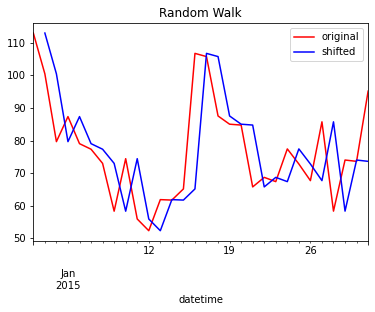

In [86]:
fig, ax = plt.subplots()

train[0:30].plot(ax=ax, c='r', label='original')
df_mk_7dwarfs_daily_random_walk[0:30].plot(ax=ax, c='b', label='shifted')
ax.set_title('Random Walk')
ax.legend();

In [87]:
np.sqrt(mean_squared_error(train[1:], df_mk_7dwarfs_daily_random_walk.dropna()))

18.683201111595267

In [88]:
residuals = df_mk_7dwarfs_daily_random_walk[1:] - train[1:]
mse = (residuals**2).sum()/len(residuals-1)
np.sqrt(mse)

18.683201111595267

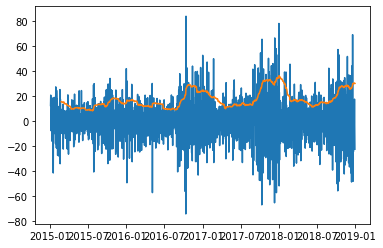

In [89]:
fig, ax = plt.subplots()

ax.plot(residuals.index, residuals)
ax.plot(residuals.index, residuals.rolling(52).std());

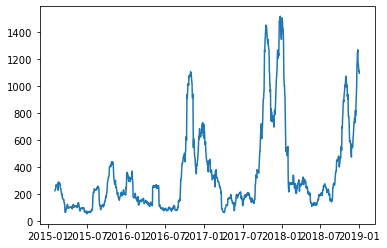

In [90]:
fig, ax = plt.subplots()

ax.plot(residuals.index, residuals.rolling(30).var());

In [91]:
print(1/0)

ZeroDivisionError: division by zero

### ARIMA Model

In [92]:
df_mk_7dwarfs_daily_arima = ARIMA(train, order=(3,1,3)).fit()


In [93]:
df_mk_7dwarfs_daily_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              CleanTime   No. Observations:                 1460
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -5885.895
Date:                Tue, 08 Mar 2022   AIC                          11785.790
Time:                        13:03:12   BIC                          11822.788
Sample:                    01-02-2015   HQIC                         11799.592
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5631      0.036    -43.097      0.000      -1.634      -1.492
ar.L2         -0.5812      0.063     -9.203      0.000      -0.705      -0.457
ar.L3          0.2242      0.034      6.599      0.000       0.158       0.291
ma.L1          0.9349      0.028     32.914      0.000       0.879       0.991
ma.L2         -0.4241      0.038    -11.206      0.000      -0.498      -0.350
ma.L3         -0.7087      0.021    -33.159      0.000      -0.751      -0.667
sigma2       186.5846      5.379     34.690      0.000     176.043     197.126
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               203.00
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               2.23   Skew:                             0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [94]:
print("AIC - ARIMA Model:", df_mk_7dwarfs_daily_arima.aic)


AIC - ARIMA Model: 11785.789605808015


#### PACF

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


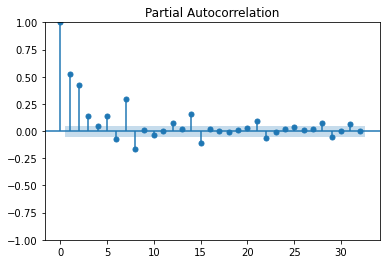

In [95]:
plot_pacf(train);

#### ACF

In [96]:
df = pd.DataFrame(train)
df.columns = ['lag_0']
df['lag_1'] = train.shift()
df.head()

,lag_0,lag_1
datetime,,
2015-01-02,112.993421,NaN
2015-01-03,100.469697,112.993421
2015-01-04,79.685039,100.469697
2015-01-05,87.370690,79.685039
2015-01-06,79.066667,87.370690


In [97]:
gamma_1 = sum(((df['lag_0'][1:]-df['lag_0'][1:].mean()) *\
               (df['lag_1'].dropna()-df['lag_1'].dropna().mean())))/(len(df['lag_1'])-1)
gamma_1

194.99013413810863

In [98]:
#Pearson Correlation
rho = gamma_1/(df.lag_0[1:].std(ddof=0)*df.lag_1.std(ddof=0))
rho

0.5276849513620424

In [99]:
df = pd.DataFrame(train)
df.columns = ['lag_0']
df['lag_1'] = train.shift()
df['lag_2'] = train.shift(2)
df['lag_3'] = train.shift(3)
df['lag_4'] = train.shift(4)
df['lag_5'] = train.shift(5)
df.corr()

,lag_0,lag_1,lag_2,lag_3,lag_4,lag_5
lag_0,1.000000,0.527685,0.584016,0.485603,0.444830,0.466850
lag_1,0.527685,1.000000,0.525831,0.583067,0.482827,0.441686
lag_2,0.584016,0.525831,1.000000,0.524808,0.581649,0.480995
lag_3,0.485603,0.583067,0.524808,1.000000,0.523642,0.580648
lag_4,0.444830,0.482827,0.581649,0.523642,1.000000,0.521481
lag_5,0.466850,0.441686,0.480995,0.580648,0.521481,1.000000


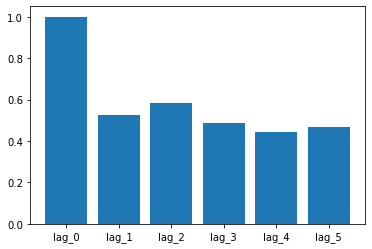

In [100]:
list(df.corr()['lag_0'].index)
plt.bar(list(df.corr()['lag_0'].index), list(df.corr()['lag_0']));

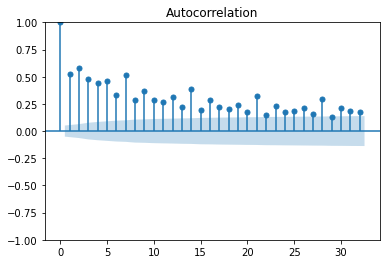

In [101]:
plot_acf(train);

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


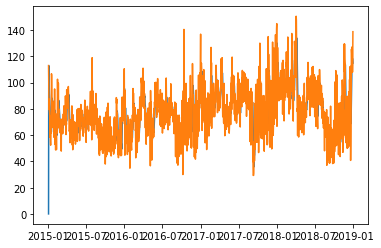

In [102]:
df_mk_7dwarfs_daily_arima2 = ARIMA(train, order=(1, 1, 2)).fit()
y_hat_train = df_mk_7dwarfs_daily_arima2.predict(typ='levels')

fig, ax = plt.subplots()
ax.plot(y_hat_train)
ax.plot(train);

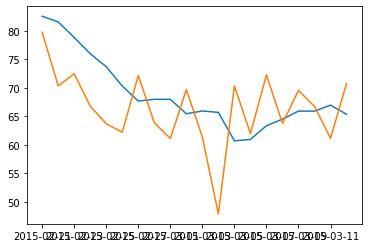

In [103]:
fig, ax = plt.subplots()
ax.plot(y_hat_train[50:70])
ax.plot(train[50:70]);

In [104]:
df_mk_7dwarfs_daily_arima2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              CleanTime   No. Observations:                 1460
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -5997.738
Date:                Tue, 08 Mar 2022   AIC                          12003.477
Time:                        13:03:18   BIC                          12024.619
Sample:                    01-02-2015   HQIC                         12011.364
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4633      0.156     -2.972      0.003      -0.769      -0.158
ma.L1         -0.3108      0.159     -1.949      0.051      -0.623       0.002
ma.L2         -0.2253      0.121     -1.857      0.063      -0.463       0.012
sigma2       217.7599      6.594     33.025      0.000     204.836     230.684
===================================================================================
Ljung-Box (L1) (Q):                   0.52   Jarque-Bera (JB):                80.94
Prob(Q):                              0.47   Prob(JB):                         0.00
Heteroskedasticity (H):               2.51   Skew:                             0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

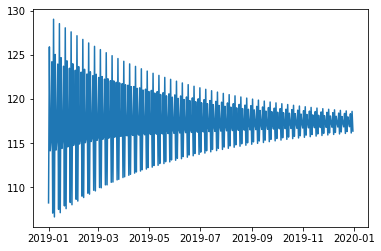

In [105]:
y_hat_test = df_mk_7dwarfs_daily_arima.predict(start=test.index[0], end=test.index[-1])

fig, ax = plt.subplots()
ax.plot(y_hat_test);

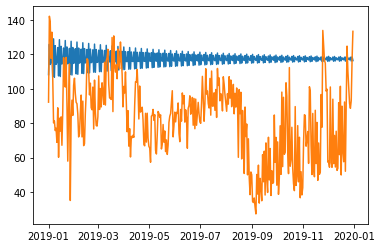

In [106]:
fig, ax = plt.subplots()
ax.plot(y_hat_test)
ax.plot(test);

In [107]:
np.sqrt(mean_squared_error(test, y_hat_test))

41.73915635912372

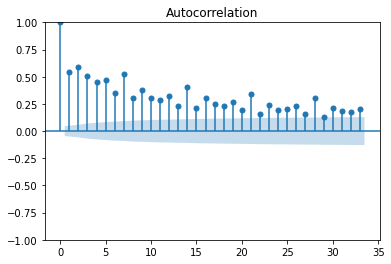

In [108]:
plot_acf(df_mk_7dwarfs_daily);

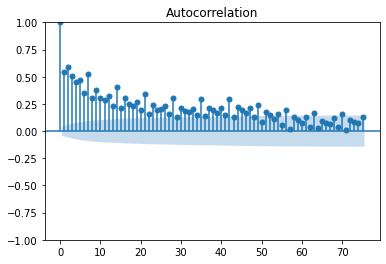

In [109]:
plot_acf(df_mk_7dwarfs_daily, lags=75);

In [110]:
p = q = range(0, 5)
pdq = list(itertools.product(p, [0], q))
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, [1], q))]
print('Examples of parameter for SARIMA...')
for i in pdq:
    for s in seasonal_pdq:
        print('SARIMAX: {} x {}'.format(i, s))

Examples of parameter for SARIMA...
SARIMAX: (0, 0, 0) x (0, 1, 0, 7)
SARIMAX: (0, 0, 0) x (0, 1, 1, 7)
SARIMAX: (0, 0, 0) x (0, 1, 2, 7)
SARIMAX: (0, 0, 0) x (0, 1, 3, 7)
SARIMAX: (0, 0, 0) x (0, 1, 4, 7)
SARIMAX: (0, 0, 0) x (1, 1, 0, 7)
SARIMAX: (0, 0, 0) x (1, 1, 1, 7)
SARIMAX: (0, 0, 0) x (1, 1, 2, 7)
SARIMAX: (0, 0, 0) x (1, 1, 3, 7)
SARIMAX: (0, 0, 0) x (1, 1, 4, 7)
SARIMAX: (0, 0, 0) x (2, 1, 0, 7)
SARIMAX: (0, 0, 0) x (2, 1, 1, 7)
SARIMAX: (0, 0, 0) x (2, 1, 2, 7)
SARIMAX: (0, 0, 0) x (2, 1, 3, 7)
SARIMAX: (0, 0, 0) x (2, 1, 4, 7)
SARIMAX: (0, 0, 0) x (3, 1, 0, 7)
SARIMAX: (0, 0, 0) x (3, 1, 1, 7)
SARIMAX: (0, 0, 0) x (3, 1, 2, 7)
SARIMAX: (0, 0, 0) x (3, 1, 3, 7)
SARIMAX: (0, 0, 0) x (3, 1, 4, 7)
SARIMAX: (0, 0, 0) x (4, 1, 0, 7)
SARIMAX: (0, 0, 0) x (4, 1, 1, 7)
SARIMAX: (0, 0, 0) x (4, 1, 2, 7)
SARIMAX: (0, 0, 0) x (4, 1, 3, 7)
SARIMAX: (0, 0, 0) x (4, 1, 4, 7)
SARIMAX: (0, 0, 1) x (0, 1, 0, 7)
SARIMAX: (0, 0, 1) x (0, 1, 1, 7)
SARIMAX: (0, 0, 1) x (0, 1, 2, 7)
SARIMAX: (0,

In [111]:
# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#         try:
#             mod=SARIMAX(train,
#                          order=param,
#                          seasonal_order=param_seasonal,
#                          enforce_stationarity=False,
#                          enforce_invertibility=False)
#             results = mod.fit()
#             print('ARIMA{}x{} - AIC:{}'.format(param,param_seasonal,results.aic))
#         except: 
#             print('Oops!')
#             continue

In [112]:
sari_mod =SARIMAX(train,
                  order=(4, 0, 4),
                  seasonal_order=(4, 1, 4, 7),
                  enforce_stationarity=False).fit()


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


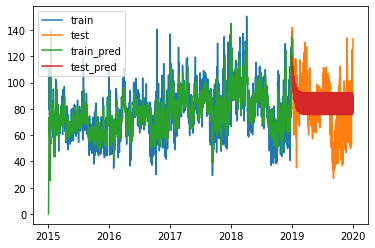

In [113]:
y_hat_train = sari_mod.predict()
y_hat_test = sari_mod.predict(start=test.index[0], end=test.index[-1])

fig, ax = plt.subplots()
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.plot(y_hat_train, label='train_pred')
ax.plot(y_hat_test, label='test_pred')

plt.legend();

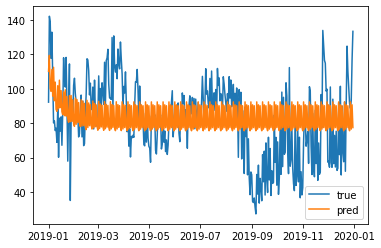

In [114]:
fig, ax = plt.subplots()

ax.plot(test, label='true')
ax.plot(y_hat_test, label='pred')

plt.legend();

In [115]:
np.sqrt(mean_squared_error(test, y_hat_test))


20.9681297773848

In [ ]:
sari_mod = SARIMAX(df_mk_7dwarfs_daily,
                  order=(4, 0, 1),
                  seasonal_order=(4, 0, 1, 365),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()

#### Forecast

In [ ]:
forecast = sari_mod.forecast(steps=365)

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))

ax.plot(df_mk_7dwarfs_daily, label='actual')
ax.plot(forecast, label='forecast')
ax.set_title('7 Dwarfs Mine Train Predictions')

plt.legend();

## Pirates of the Caribbean (NOT INCLUDED)

In [ ]:
# df_mk_pirates = pd.read_csv("data/pirates_of_caribbean.csv")
# df_mk_pirates

In [ ]:
# CleanNegatives(df_mk_pirates,'SPOSTMIN','SPOSTMINClean')
# print(df_mk_pirates)

In [ ]:
# Cleanup(df_mk_pirates,'SACTMIN','SPOSTMINClean','CleanTime')
# print(df_mk_pirates)

In [ ]:
# df_mk_pirates[df_mk_pirates.CleanTime < 0]

In [ ]:
# df_mk_pirates['datetime'] = pd.to_datetime(df_mk_pirates.datetime)
# df_mk_pirates.set_index('datetime', inplace=True)
# df_mk_pirates = df_mk_pirates['SPOSTMIN']
# df_mk_pirates

In [ ]:
# df_mk_pirates.isna().sum()

In [ ]:
# df_mk_pirates = df_mk_pirates.dropna()

In [ ]:
# df_mk_pirates_daily = df_mk_pirates.resample('D').mean()

In [ ]:
# df_mk_pirates_daily.isna().sum()

In [ ]:
# df_mk_pirates_daily = df_mk_pirates_daily.loc['2015-01-01 07:51:12':'2019-12-31 23:55:02']

In [ ]:
# df_mk_pirates_daily.plot(figsize=(15,8))

In [ ]:
# df_mk_pirates_daily = df_mk_pirates_daily.ffill()

In [ ]:
# df_mk_pirates_daily.isna().sum()

In [ ]:
# df_mk_pirates_daily.plot(figsize=(15,8))

### Splash Mountain

In [ ]:
df_mk_splash = pd.read_csv("data/splash_mountain.csv")
df_mk_splash

#### Cleaning up -999 values

In [ ]:
CleanNegatives(df_mk_splash,'SPOSTMIN','SPOSTMINClean')
print(df_mk_splash)

#### Merging Columns

In [ ]:
Cleanup(df_mk_splash,'SACTMIN','SPOSTMINClean','CleanTime')
print(df_mk_splash)

In [ ]:
df_mk_splash[df_mk_splash.CleanTime < 0]

In [ ]:
df_mk_splash['datetime'] = pd.to_datetime(df_mk_splash.datetime)
df_mk_splash.set_index('datetime', inplace=True)
df_mk_splash = df_mk_splash['SPOSTMIN']
df_mk_splash

In [ ]:
df_mk_splash.isna().sum()

In [ ]:
df_mk_splash = df_mk_splash.dropna()

In [ ]:
df_mk_splash.isna().sum()

In [ ]:
df_mk_splash_daily = df_mk_splash.resample('D').mean()

In [ ]:
df_mk_splash_daily= df_mk_splash_daily.loc['2015-01-01 07:51:12':'2019-12-31 23:55:02']

In [ ]:
df_mk_splash_daily.plot(figsize=(15,8))

In [ ]:
df_mk_splash_daily = df_mk_splash_daily.loc['2015-01-01 07:51:12':'2019-12-31 23:55:02']

In [ ]:
df_mk_splash_daily = df_mk_splash_daily.ffill()

In [ ]:
df_mk_splash_daily.isna().sum()

In [ ]:
df_mk_splash_daily.plot()

In [ ]:
pvalue = adfuller(df_mk_splash_daily)[1]
is_stationary = pvalue<= .05

is_stationary

## ANIMAL KINGDOM

### Dinosaur Ride

In [ ]:
df_ak_dinosaur = pd.read_csv("data/dinosaur.csv")
df_ak_dinosaur

In [ ]:
CleanNegatives(df_ak_dinosaur,'SPOSTMIN','SPOSTMINClean')
print(df_ak_dinosaur)

In [ ]:
Cleanup(df_ak_dinosaur,'SACTMIN','SPOSTMINClean','CleanTime')
print(df_ak_dinosaur)

In [ ]:
df_ak_dinosaur[df_ak_dinosaur.CleanTime < 0]

In [ ]:
df_ak_dinosaur['datetime'] = pd.to_datetime(df_ak_dinosaur.datetime)
df_ak_dinosaur.set_index('datetime', inplace=True)
df_ak_dinosaur = df_ak_dinosaur['SPOSTMIN']
df_ak_dinosaur

In [ ]:
df_ak_dinosaur.isna().sum()

In [ ]:
df_ak_dinosaur = df_ak_dinosaur.dropna()

In [ ]:
df_ak_dinosaur.isna().sum()

In [ ]:
df_ak_dinosaur_daily = df_ak_dinosaur.resample('D').mean()

In [ ]:
df_ak_dinosaur_daily = df_ak_dinosaur_daily.loc['2015-01-01 07:51:12':'2019-12-31 23:55:02']

In [ ]:
df_ak_dinosaur_daily.plot(figsize=(15,8))

In [ ]:
df_ak_dinosaur_daily = df_ak_dinosaur_daily.ffill()

In [ ]:
df_ak_dinosaur.isna().sum()

In [ ]:
df_ak_dinosaur_daily.plot(figsize=(15,8))

### Expedition Everest

In [ ]:
df_ak_everest =pd.read_csv("data/expedition_everest.csv")
df_ak_everest

In [ ]:
CleanNegatives(df_ak_everest,'SPOSTMIN','SPOSTMINClean')
print(df_ak_everest)

In [ ]:
Cleanup(df_ak_everest,'SACTMIN','SPOSTMINClean','CleanTime')
print(df_ak_everest)

In [ ]:
df_ak_everest[df_ak_everest.CleanTime < 0]

In [ ]:
df_ak_everest['datetime'] = pd.to_datetime(df_ak_everest.datetime)
df_ak_everest.set_index('datetime', inplace=True)
df_ak_everest = df_ak_everest['SPOSTMIN']
df_ak_everest

In [ ]:
df_ak_everest = df_ak_everest.dropna()

In [ ]:
df_ak_everest.isna().sum()

In [ ]:
df_ak_everest_daily = df_ak_everest.resample('D').mean()

In [ ]:
df_ak_everest_daily = df_ak_everest_daily.loc['2015-01-01 07:51:12':'2019-12-31 23:55:02']

In [ ]:
df_ak_everest.isna().sum()

In [ ]:
df_ak_everest_daily.plot(figsize=(15,8))

### Kilimajaro Safaris

In [ ]:
df_ak_safari =pd.read_csv("data/kilimanjaro_safaris.csv")
df_ak_safari

In [ ]:
CleanNegatives(df_ak_safari,'SPOSTMIN','SPOSTMINClean')
print(df_ak_safari)

In [ ]:
Cleanup(df_ak_safari,'SACTMIN','SPOSTMINClean','CleanTime')
print(df_ak_safari)

In [ ]:
df_ak_safari[df_ak_safari.CleanTime < 0]

In [ ]:
df_ak_safari = df_ak_safari[df_ak_safari['CleanTime'] >= 0]

In [ ]:
df_ak_safari['datetime'] = pd.to_datetime(df_ak_safari.datetime)
df_ak_safari.set_index('datetime', inplace=True)
df_ak_safari = df_ak_safari['SPOSTMIN']
df_ak_safari

In [ ]:
df_ak_safari.isna().sum()

In [ ]:
df_ak_safari = df_ak_safari.dropna()

In [ ]:
df_ak_safari_daily = df_ak_safari.resample('D').mean()

In [ ]:
df_ak_safari_daily = df_ak_safari_daily.loc['2015-01-01 07:51:12':'2019-12-31 23:55:02']

In [ ]:
df_ak_safari_daily.isna().sum()

In [ ]:
df_ak_safari_daily = df_ak_safari_daily.ffill()

In [ ]:
df_ak_safari_daily.isna().sum()

In [ ]:
df_ak_safari_daily.plot(figsize=(15,8))

### Navi River

In [ ]:
df_ak_naviriver = pd.read_csv("data/navi_river.csv")
df_ak_naviriver

In [ ]:
CleanNegatives(df_ak_naviriver,'SPOSTMIN','SPOSTMINClean')
print(df_ak_naviriver)

In [ ]:
df_ak_naviriver[df_ak_naviriver.SPOSTMINClean < 0]

In [ ]:
Cleanup(df_ak_naviriver,'SACTMIN','SPOSTMINClean','CleanTime')
print(df_ak_naviriver)

In [ ]:
df_ak_naviriver[df_ak_naviriver.CleanTime < 0]

In [ ]:
df_ak_naviriver['datetime'] = pd.to_datetime(df_ak_naviriver.datetime)
df_ak_naviriver.set_index('datetime', inplace=True)
df_ak_naviriver = df_ak_naviriver['SPOSTMIN']
df_ak_naviriver

In [ ]:
df_ak_naviriver = df_ak_naviriver.dropna()

In [ ]:
df_ak_naviriver.isna().sum()

In [ ]:
df_ak_naviriver_daily = df_ak_naviriver.resample('D').mean()

In [ ]:
df_ak_naviriver_daily = df_ak_naviriver_daily.loc['2015-01-01 07:51:12':'2019-12-31 23:55:02']

In [ ]:
df_ak_naviriver_daily.plot(figsize=(15,8))

In [ ]:
df_ak_naviriver_daily.isna().sum()

In [ ]:
df_ak_naviriver_daily = df_ak_naviriver_daily.ffill()

In [ ]:
df_ak_naviriver_daily.isna().sum()

In [ ]:
df_navi_river = df_ak_naviriver_daily.reset_index()
df_navi_river.columns = ['ds', 'y']
df_navi_river.head()

In [ ]:
prediction_size = 30
train_df_navi_river = df_navi_river[:-prediction_size]

In [ ]:
train_df_navi_river

In [ ]:
m = Prophet()
m.fit(train_df_navi_river)

## EPCOT

### Soarin

In [ ]:
df_ec_soarin = pd.read_csv("data/soarin.csv")
df_ec_soarin

In [ ]:
CleanNegatives(df_ec_soarin,'SPOSTMIN','SPOSTMINClean')
print(df_ec_soarin)

In [ ]:
Cleanup(df_ec_soarin,'SACTMIN','SPOSTMINClean','CleanTime')
print(df_ec_soarin)

In [ ]:
df_ec_soarin[df_ec_soarin.CleanTime < 0]

In [ ]:
df_ec_soarin['datetime'] = pd.to_datetime(df_ec_soarin.datetime)
df_ec_soarin.set_index('datetime', inplace=True)
df_ec_soarin = df_ec_soarin['SPOSTMIN']
df_ec_soarin

In [ ]:
df_ec_soarin.isna().sum()

In [ ]:
df_ec_soarin.dropna()

In [ ]:
df_ec_soarin_daily = df_ec_soarin.resample('D').mean()

In [ ]:
df_ec_soarin_daily = df_ec_soarin_daily.loc['2015-01-01 07:51:12':'2019-12-31 23:55:02']

In [ ]:
df_ec_soarin_daily.plot(figsize=(15,8))

In [ ]:
df_ec_soarin_daily = df_ec_soarin_daily.ffill()

In [ ]:
df_ec_soarin_daily.plot(figsize=(15,8))

### Spaceship Earth

In [ ]:
df_ec_spaceship = pd.read_csv("data/spaceship_earth.csv")
df_ec_spaceship

In [ ]:
CleanNegatives(df_ec_spaceship,'SPOSTMIN','SPOSTMINClean')
print(df_ec_spaceship)

In [ ]:
Cleanup(df_ec_spaceship,'SACTMIN','SPOSTMINClean','CleanTime')
print(df_ec_spaceship)

In [ ]:
df_ec_spaceship[df_ec_spaceship.CleanTime < 0]

In [ ]:
df_ec_spaceship['datetime'] = pd.to_datetime(df_ec_spaceship.datetime)
df_ec_spaceship.set_index('datetime', inplace=True)
df_ec_spaceship = df_ec_spaceship['SPOSTMIN']
df_ec_spaceship

In [ ]:
df_ec_spaceship = df_ec_spaceship.dropna()

In [ ]:
df_ec_spaceship.isna().sum()

In [ ]:
df_ec_spaceship_daily = df_ec_spaceship.resample('D').mean()

In [ ]:
df_ec_spaceship_daily= df_ec_spaceship_daily.loc['2015-01-01 07:51:12':'2019-12-31 23:55:02']

In [ ]:
df_ec_spaceship_daily.plot(figsize=(15,8))

In [ ]:
df_ec_spaceship.isna().sum()

## HOLLYWOOD STUDIOS

### Slinky Dog Ride

In [ ]:
df_hs_slinky = pd.read_csv("data/slinky_dog.csv")
df_hs_slinky

In [ ]:
CleanNegatives(df_hs_slinky,'SPOSTMIN','SPOSTMINClean')
print(df_hs_slinky)

In [ ]:
Cleanup(df_hs_slinky,'SACTMIN','SPOSTMINClean','CleanTime')
print(df_hs_slinky)

In [ ]:
df_hs_slinky[df_hs_slinky.CleanTime < 0]

In [ ]:
df_hs_slinky['datetime'] = pd.to_datetime(df_hs_slinky.datetime)
df_hs_slinky.set_index('datetime', inplace=True)
df_hs_slinky = df_hs_slinky['SPOSTMIN']
df_hs_slinky

In [ ]:
df_hs_slinky.isna().sum()

In [ ]:
df_hs_slinky = df_hs_slinky.dropna()

In [ ]:
df_hs_slinky.isna().sum()

In [ ]:
df_hs_slinky_daily = df_hs_slinky.resample('D').mean()

In [ ]:
df_hs_slinky_daily = df_hs_slinky_daily.loc['2015-01-01 07:51:12':'2019-12-31 23:55:02']

In [ ]:
df_hs_slinky_daily.plot(figsize=(15,8))

In [ ]:
df_hs_slinky.isna().sum()

### Toy Story

In [ ]:
df_hs_toystory = pd.read_csv("data/toy_story_mania.csv")
df_hs_toystory

In [ ]:
CleanNegatives(df_hs_toystory,'SPOSTMIN','SPOSTMINClean')
print(df_hs_toystory)

In [ ]:
Cleanup(df_hs_toystory,'SACTMIN','SPOSTMINClean','CleanTime')
print(df_hs_toystory)

In [ ]:
df_hs_toystory[df_hs_toystory.CleanTime < 0]

In [ ]:
df_hs_toystory['datetime'] = pd.to_datetime(df_hs_toystory.datetime)
df_hs_toystory.set_index('datetime', inplace=True)
df_hs_toystory = df_hs_toystory['SPOSTMIN']
df_hs_toystory

In [ ]:
df_hs_toystory.isna().sum()

In [ ]:
df_hs_toystory = df_hs_toystory.dropna()

In [ ]:
df_hs_toystory.isna().sum()

In [ ]:
df_hs_toystory_daily = df_hs_toystory.resample('D').mean()

In [ ]:
df_hs_toystory_daily.plot(figsize=(15,8))

In [ ]:
df_hs_toystory_daily = df_hs_toystory_daily.loc['2015-01-01 07:51:12':'2019-12-31 23:55:02']

In [ ]:
df_hs_toystory_daily[df_hs_toystory_daily.isna()]

In [ ]:
df_hs_toystory_daily = df_hs_toystory_daily.ffill()

In [ ]:
df_hs_toystory_daily[df_hs_toystory_daily.isna()]

In [ ]:
df_hs_toystory_daily.plot(figsize=(15,8))

### Rock -n- Roller Coaster

In [ ]:
df_hs_rockin = pd.read_csv('data/rock_n_rollercoaster.csv')
df_hs_rockin 

In [ ]:
CleanNegatives(df_hs_rockin,'SPOSTMIN','SPOSTMINClean')
print(df_hs_rockin) 

In [ ]:
Cleanup(df_hs_rockin,'SACTMIN','SPOSTMINClean','CleanTime')
print(df_hs_rockin)

In [ ]:
df_hs_rockin[df_hs_rockin.CleanTime < 0]

In [ ]:
df_hs_rockin[df_hs_rockin.CleanTime < 0]

In [ ]:
df_hs_rockin = df_hs_rockin[df_hs_rockin['CleanTime'] >= 0]

In [ ]:
df_hs_rockin.isna().sum()

In [ ]:
df_hs_rockin['datetime'] = pd.to_datetime(df_hs_rockin.datetime)
df_hs_rockin.set_index('datetime', inplace=True)
df_hs_rockin = df_hs_rockin['SPOSTMIN']
df_hs_rockin

In [ ]:
df_hs_rockin = df_hs_rockin.dropna()

In [ ]:
df_hs_rockin_daily = df_hs_rockin.resample('D').mean()

In [ ]:
df_hs_rockin_daily = df_hs_rockin_daily.loc['2015-01-01 07:51:12':'2019-12-31 23:55:02']

In [ ]:
df_hs_rockin_daily.plot(figsize=(15,8))

In [ ]:
df_hs_rockin.isna().sum()

### Entities for Rides

In [ ]:
df_entities = pd.read_csv("data/entities.csv")    
df_entities

### Metadata

In [ ]:
df_metadata = pd.read_csv("data/metadata.csv")
df_metadata